# **1. Problem Defining:**
Input của bài toán là các thông tin liên quan đến người bệnh. Dựa vào các thông tin đó, xây dựng model để đoán số ngày người đó nhập viện (Stay_Days), phục vụ cho việc tính toán giường bệnh và cơ sở vật chất của bệnh viện.


# **2. Data Collecting:**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import imblearn
import io
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.utils import resample
from xgboost import XGBClassifier, XGBRegressor

In [ ]:
train = pd.read_csv('/content/host_train.csv')

In [ ]:
train.head()

,case_id,Hospital,Hospital_type,Hospital_city,Hospital_region,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility,Bed_Grade,patientid,City_Code_Patient,Type of Admission,Illness_Severity,Patient_Visitors,Age,Admission_Deposit,Stay_Days
0,1,8,2,3,2,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,2,5,2,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,4,1,0,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,1,2,1,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,1,2,1,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [ ]:
train.shape

(318438, 18)

# **3. Data analyzing:**

## **3.1. Tổng quan các trường dữ liệu**

In [ ]:
print(train['Stay_Days'])

0          0-10
1         41-50
2         31-40
3         41-50
4         41-50
          ...  
318433    11-20
318434    31-40
318435    11-20
318436    11-20
318437     0-10
Name: Stay_Days, Length: 318438, dtype: object


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital                           318438 non-null  int64  
 2   Hospital_type                      318438 non-null  int64  
 3   Hospital_city                      318438 non-null  int64  
 4   Hospital_region                    318438 non-null  int64  
 5   Available_Extra_Rooms_in_Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility                      318438 non-null  object 
 9   Bed_Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [ ]:
train.describe()

,case_id,Hospital,Hospital_type,Hospital_city,Hospital_region,Available_Extra_Rooms_in_Hospital,Bed_Grade,patientid,City_Code_Patient,Patient_Visitors,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,1.256841,4.771717,0.778098,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276847,8.633755,1.535712,3.102535,0.752527,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,0.000000,2.000000,0.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,1.000000,5.000000,1.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,2.000000,7.000000,1.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,6.000000,13.000000,2.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


In [ ]:
train.isna().sum()

case_id                                 0
Hospital                                0
Hospital_type                           0
Hospital_city                           0
Hospital_region                         0
Available_Extra_Rooms_in_Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility                           0
Bed_Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Illness_Severity                        0
Patient_Visitors                        0
Age                                     0
Admission_Deposit                       0
Stay_Days                               0
dtype: int64

Trường Bed_Grade là trường số nên sẽ fill mean, trường City_Code_Patient là trường phân loại nên fill 0.

In [ ]:
train['Bed_Grade'].fillna(value=np.mean(train['Bed_Grade']),inplace=True)
train['City_Code_Patient'].fillna(value=39,inplace=True)

## **3.2. Metric đánh giá**

Đôi với bài toán Regression, sử dụng RMSE.
Đôi với bài toán Classification, sử dụng confusion matrix và f1-score để đánh giá.

## **3.3. Xử lý một số trường trong dataset:**

### Case_id và patientid

Hai cột này không cần thiết và không ảnh hưởng đến dữ liệu nên sẽ loại đi ngay.

In [ ]:
train.drop(columns=['case_id','patientid'],inplace=True)

### Target - Stay_Days

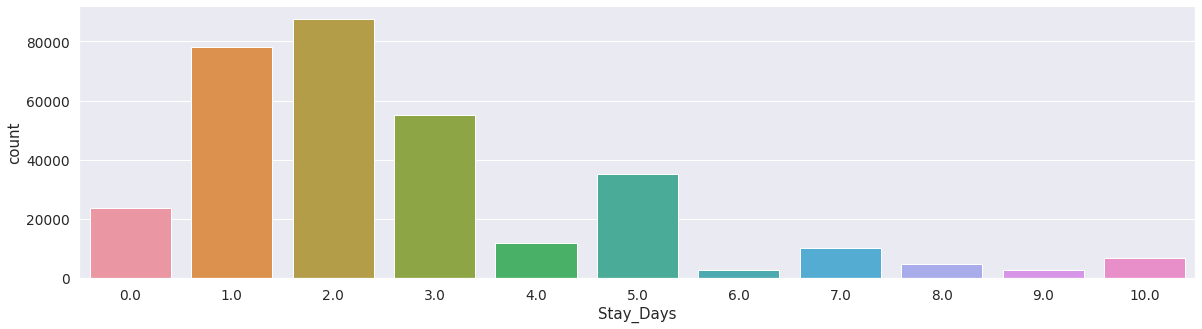

In [ ]:
train['target'] = np.zeros(train.shape[0])

sd = {'0-10':0,'11-20':1,'21-30':2,'31-40':3,'41-50':4,'51-60':5,'61-70':6,'71-80':7,'81-90':8,'91-100':9,'More than 100 Days':10}

for i in sd:
  train.loc[train.loc[:,'Stay_Days'] == i,'target'] = int(sd[i])

train['Stay_Days'] = train['target'].copy()
train.drop(columns='target', inplace=True)

plt.figure(figsize=(20,5))
sns.countplot(x='Stay_Days',data=train)

### Label Encoding một số trường

In [ ]:
le = LabelEncoder()
train['Ward_Facility']= le.fit_transform(train['Ward_Facility'])
train['Age']= le.fit_transform(train['Age'])
train['Ward_Type']= le.fit_transform(train['Ward_Type'])

Is = { 'Moderate':2, 'Minor':1, 'Extreme':3 }
train['illness_severity'] = np.zeros(train.shape[0])
for i in Is:
    train.loc[train.loc[:,'Illness_Severity']==i,'illness_severity'] = Is[i]
train['Illness_Severity'] = train['illness_severity']
train.drop(columns='illness_severity',inplace=True)

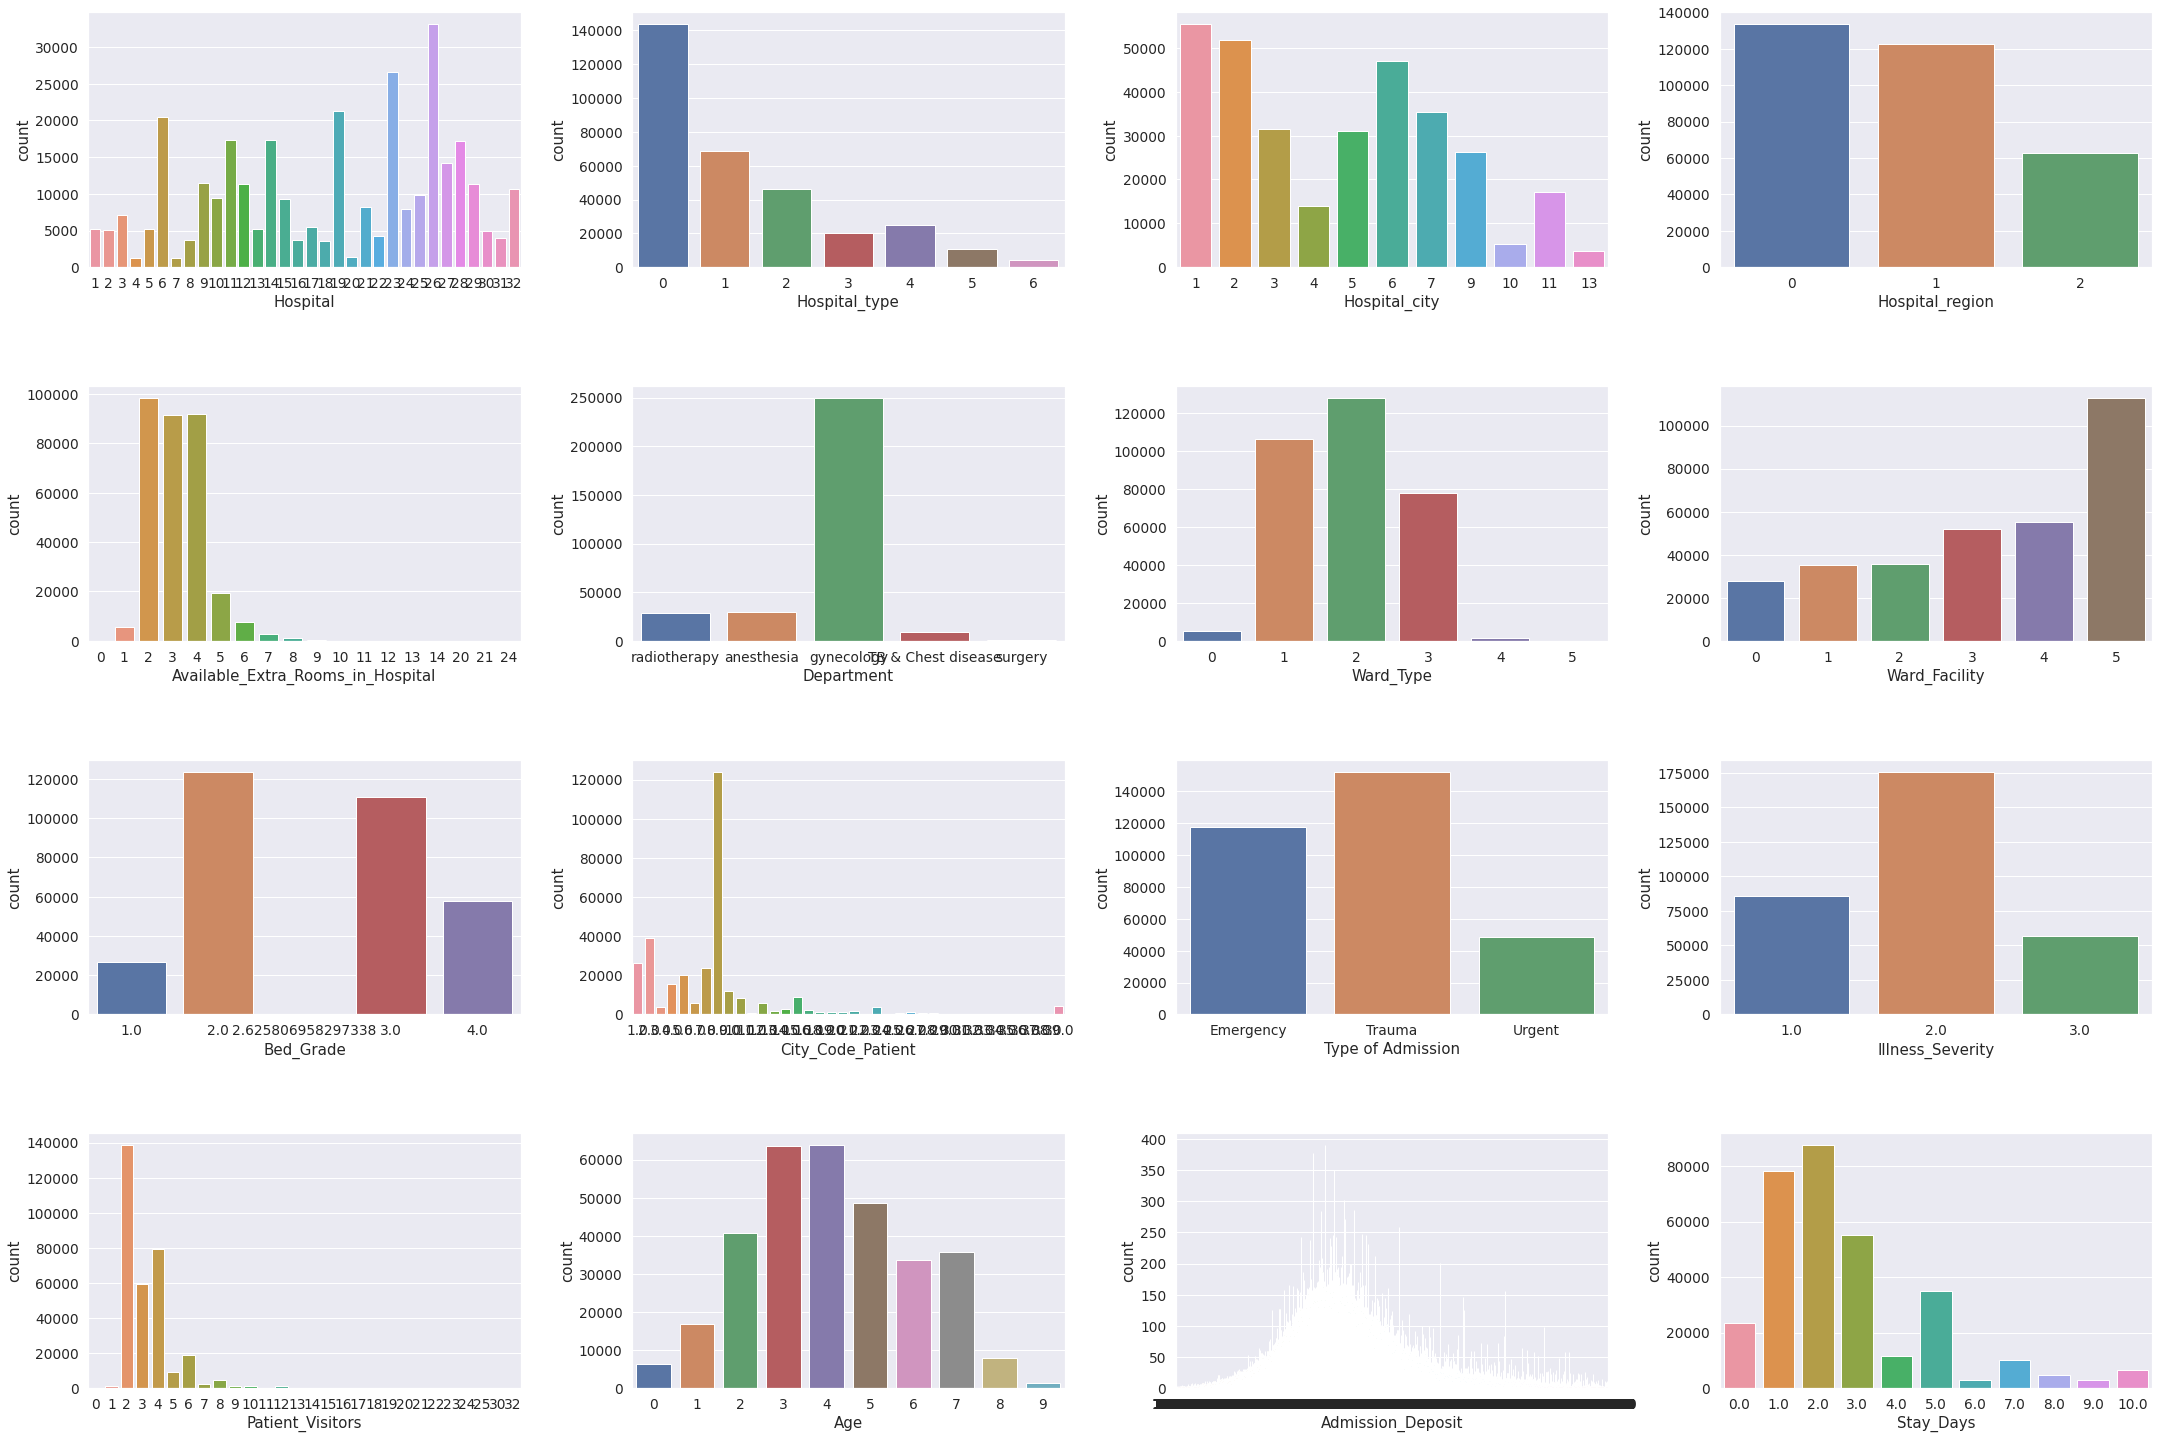

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize = (30,20))
index = 0
ax = ax.flatten()
for col in train.items():
  sns.countplot(x=col[0], data=train, ax=ax[index])
  index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

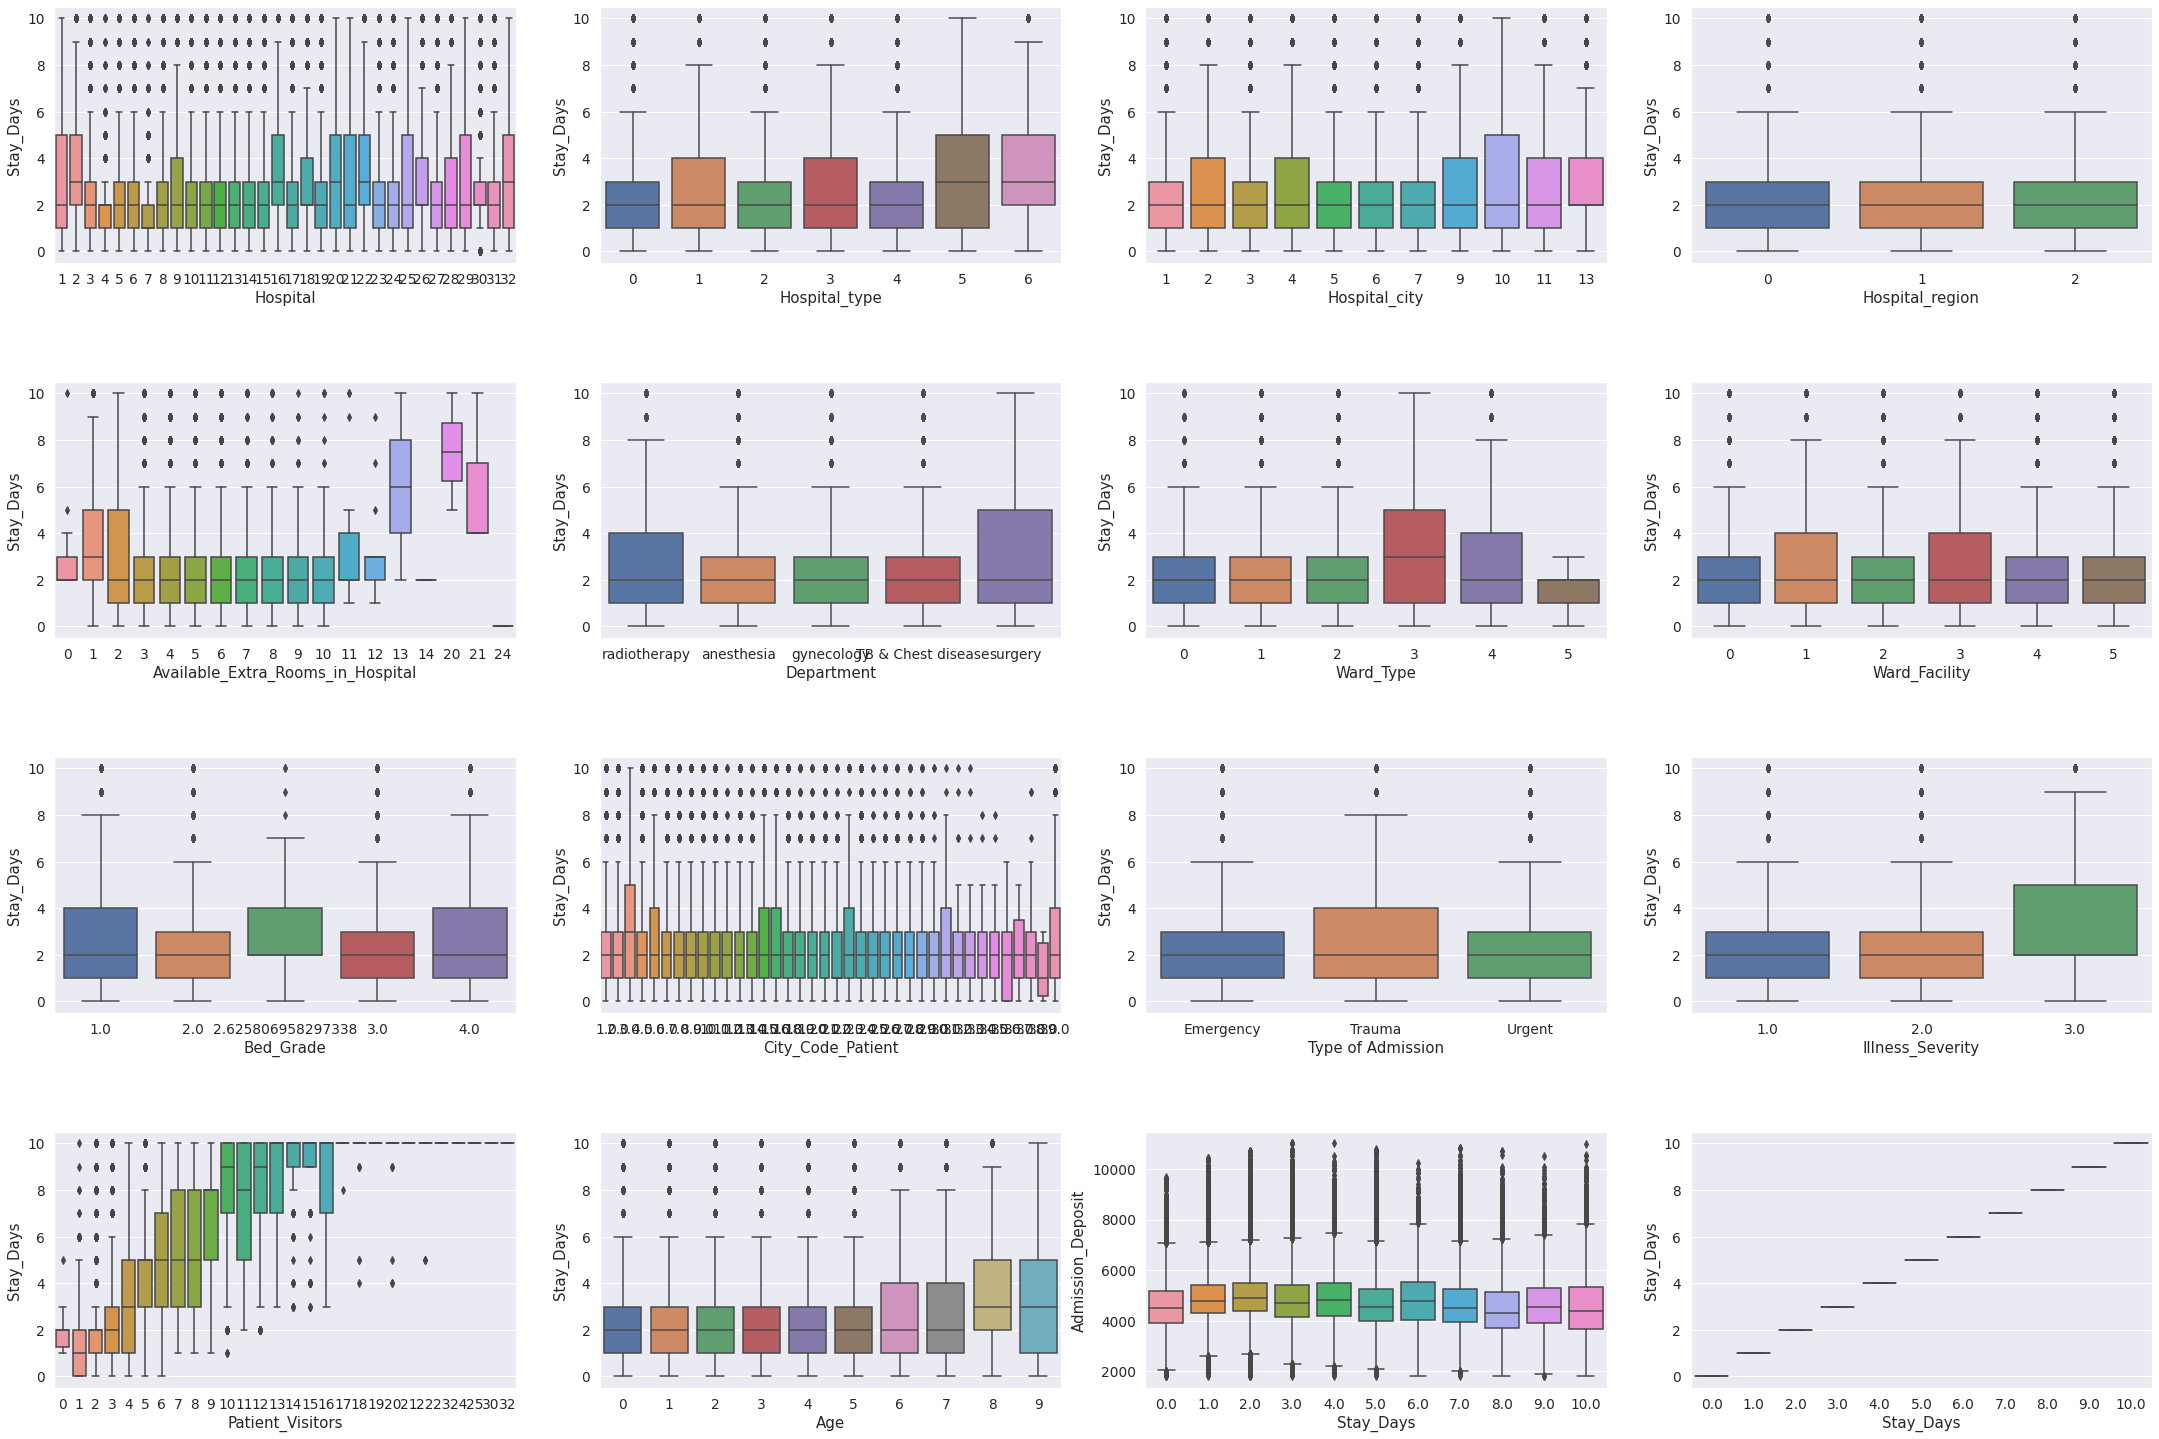

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize = (30,20))
index = 0
ax = ax.flatten()
for col in train.items():
  if col[0]!='Admission_Deposit': sns.boxplot(x=col[0], data=train, y='Stay_Days',ax=ax[index])
  else: sns.boxplot(y=col[0], data=train, x='Stay_Days',ax=ax[index])
  index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

In [ ]:
for i in train['Hospital'].unique():
    print('So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital '+str(i)+' la: ' + 
            str(train.Hospital_type[train.loc[:,'Hospital']==i].unique().shape[0]) + ' ' + 
            str(train.Hospital_city[train.loc[:,'Hospital']==i].unique().shape[0]) + ' ' +
            str(train.Hospital_region[train.loc[:,'Hospital']==i].unique().shape[0]) )

So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 8 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 2 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 10 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 26 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 23 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 32 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 1 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 22 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 16 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 9 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 6 la: 1 1 1
So Hospital_Type, Hospital_city, Hospital_region tuong ung Hospital 29 la: 1 1 1
So Hospital_Type, Hospital_city, 

Nhận thấy là mỗi hospital chỉ có 1 hospital_type, 1 hospital_city, 1 hospital_region và 3 feature này không có khác biệt đáng kể giữa các loại category nên sẽ drop 3 feature này

In [ ]:
train.drop(columns=['Hospital_city','Hospital_type','Hospital_region'],inplace=True)

### One hot encoding các category feature

In [ ]:
Hospital_encoded = pd.DataFrame( tf.keras.utils.to_categorical(train['Hospital']) )
for i in Hospital_encoded.items():
    Hospital_encoded.rename(columns={i[0]:'Hospital_'+str(i[0])},inplace=True)

In [ ]:
City_Code_Patient_encoded = pd.DataFrame( tf.keras.utils.to_categorical(train['City_Code_Patient']) )
for i in City_Code_Patient_encoded.items():
    City_Code_Patient_encoded.rename(columns={i[0]:'City_Code_Patient_'+str(i[0])},inplace=True)

In [ ]:
train = pd.get_dummies(train)
train = train.join([Hospital_encoded,City_Code_Patient_encoded])
train.drop(columns=['City_Code_Patient','Hospital'],inplace=True)

### Chia train/test

In [ ]:
train, X_test = train_test_split(train,test_size=0.3)
y_train = train['Stay_Days'].copy()
y_test = X_test['Stay_Days'].copy()
X_test.drop(columns='Stay_Days',inplace=True)

In [ ]:
print(train.shape,X_test.shape)

(222906, 90) (95532, 89)


## **3.4. Data exploratory**

### Vẽ correlation heatmap matrix

Text(0, 0.5, 'Features')

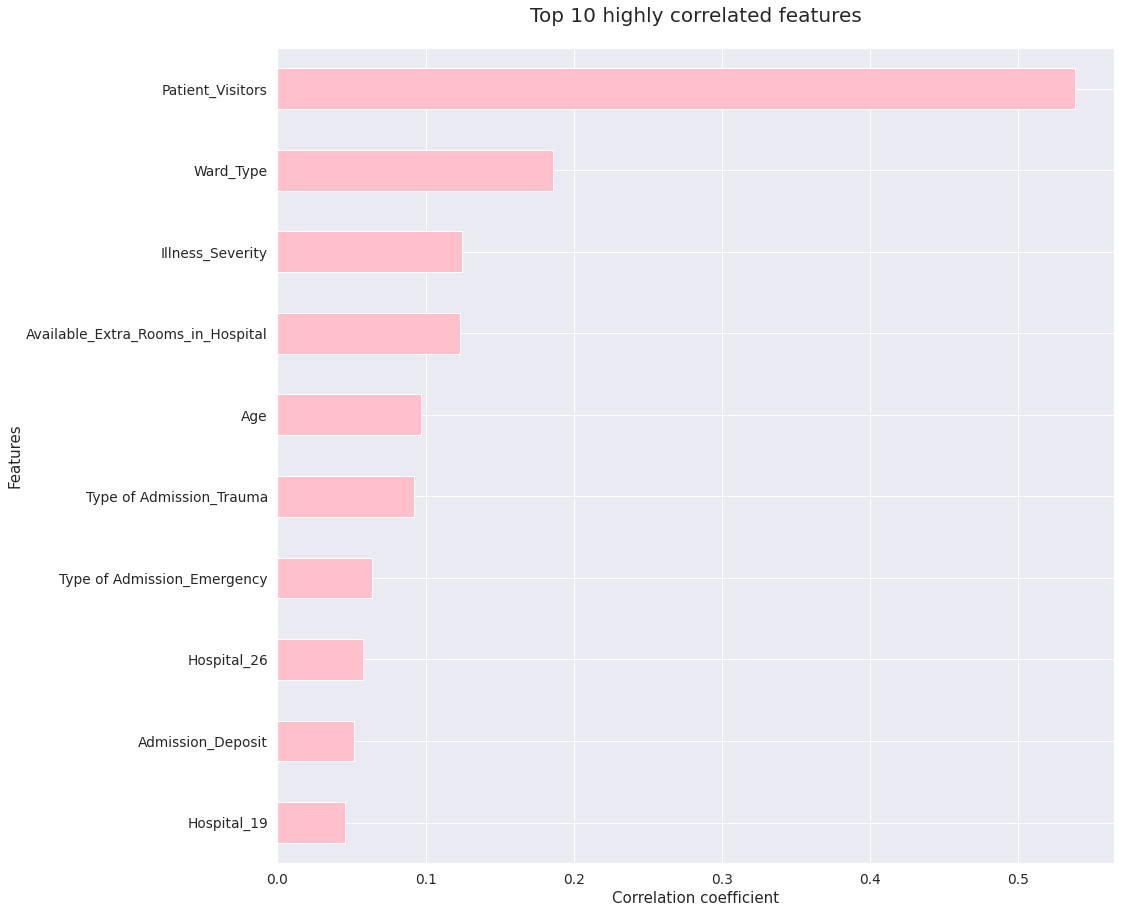

In [ ]:
plt.figure(figsize=(15,15))
train.corr().Stay_Days.apply(lambda x: abs(x)).sort_values(ascending=False).iloc[1:11][::-1].plot(kind='barh',color='pink') 
# calculating the top 10 highest correlated features
# with respect to the target variable i.e. "quality"
plt.title("Top 10 highly correlated features", size=20, pad=26)
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")

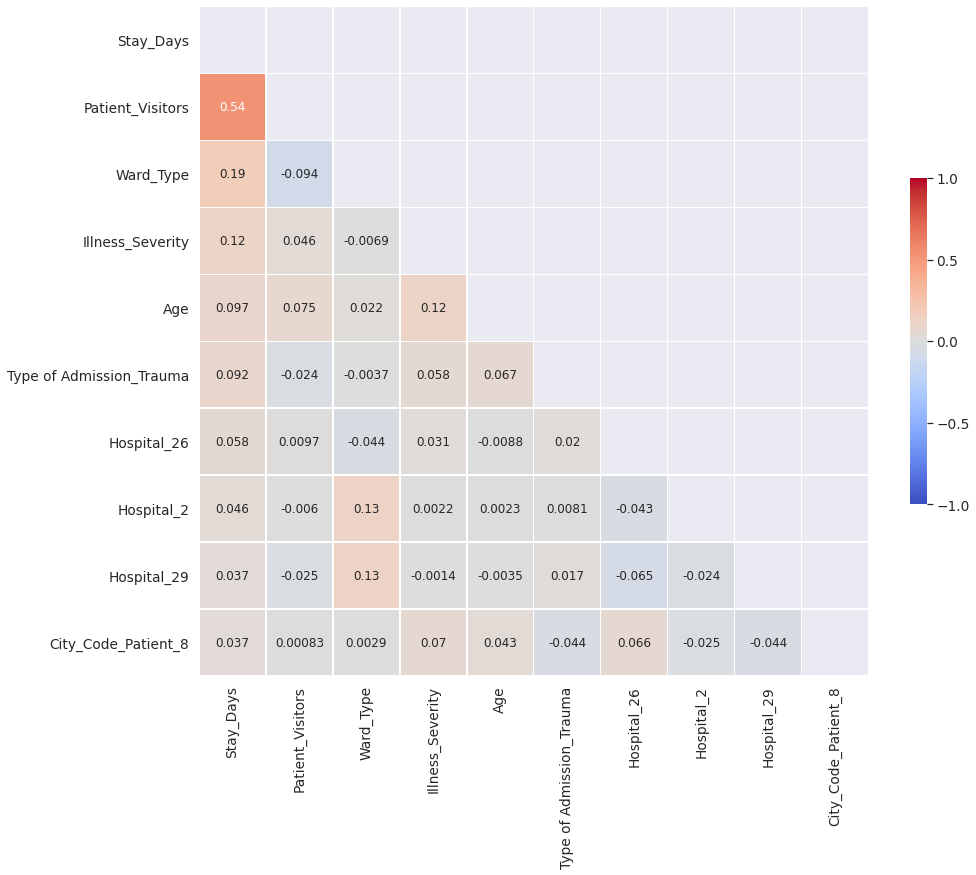

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
k = 10 #number of variables for heatmap
cols = train.corr().nlargest(k, 'Stay_Days')['Stay_Days'].index
cm = train[cols].corr()
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, mask = mask, square = True,
                 linewidths = .5,
                 cmap = 'coolwarm',
                 cbar_kws = {'shrink': .4,
                             'ticks' : [-1, -.5, 0, 0.5, 1]},
                 vmin = -1,
                 vmax = 1,
                 annot = True,
                 annot_kws = {'size': 12}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Xem xét tương quan các trường với Stay_Days

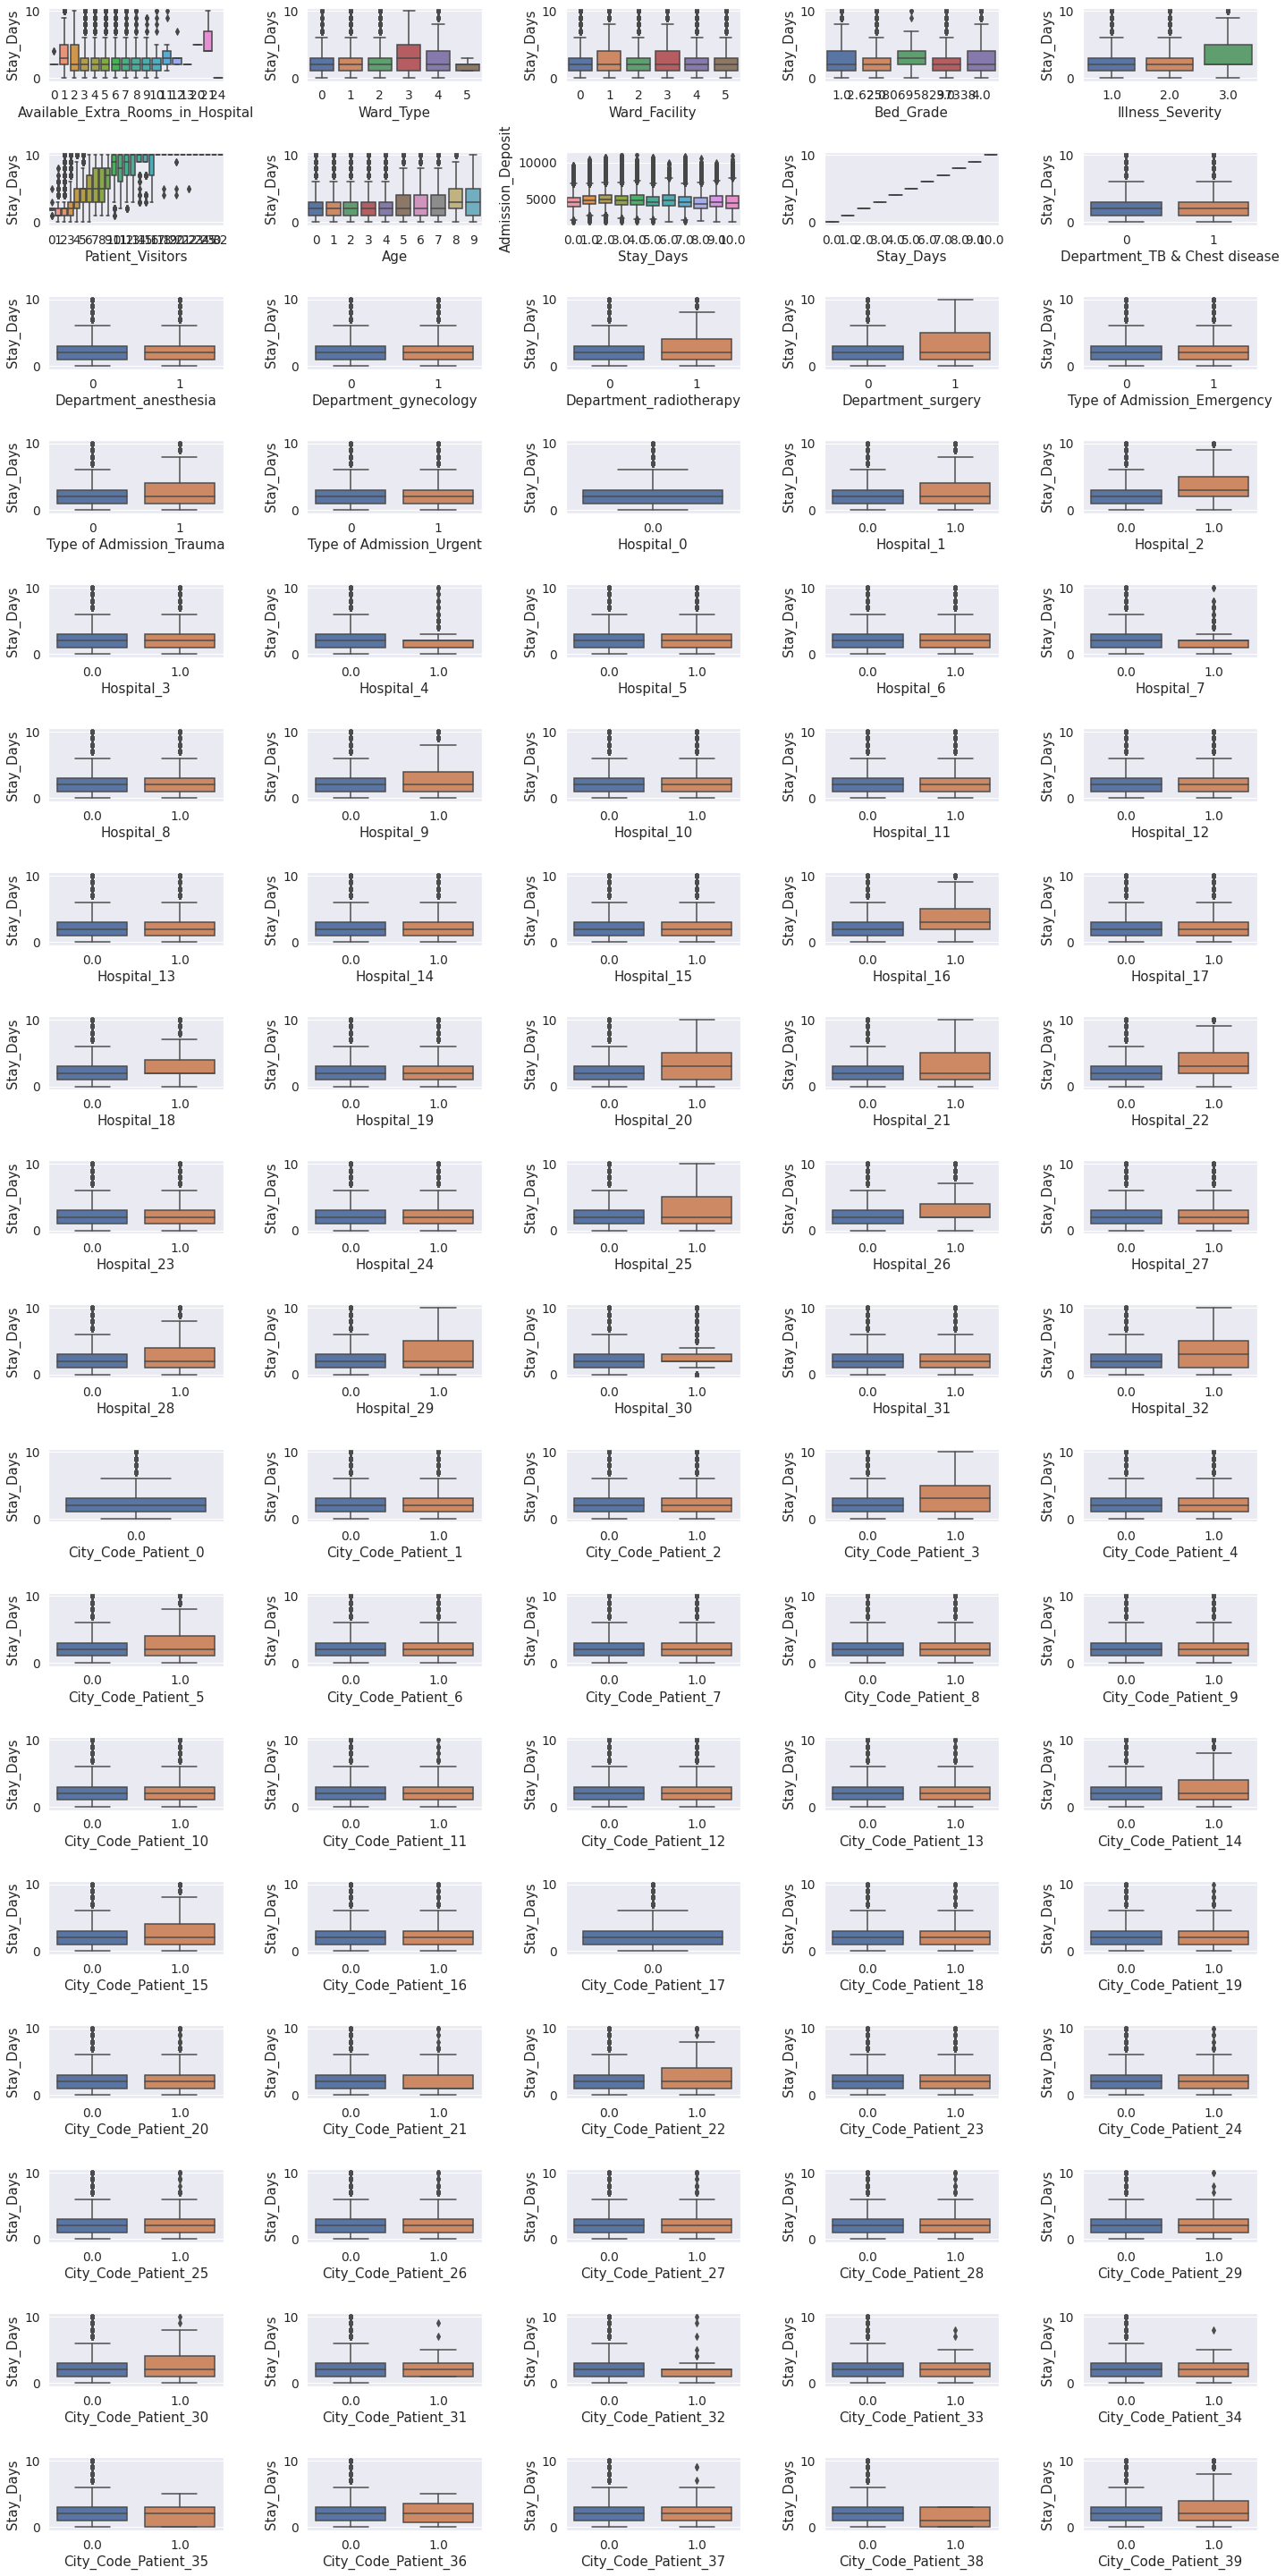

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=18, figsize = (20,40))
index = 0
ax = ax.flatten()
for col in train.items():
  if col[0]!='Admission_Deposit': sns.boxplot(x=col[0], data=train, y='Stay_Days',ax=ax[index])
  else: sns.boxplot(y=col[0], data=train, x='Stay_Days',ax=ax[index])
  index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=1.0)

#### Available_Extra_Rooms_in_Hospital

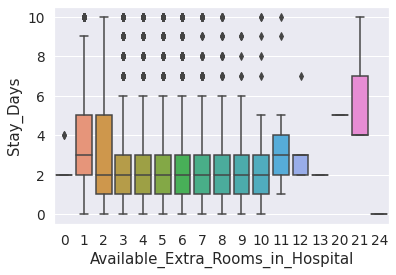

In [ ]:
sns.boxplot(y='Stay_Days', x='Available_Extra_Rooms_in_Hospital', data = train)

Có xu hướng cao khi Available_Extra_Rooms_in_Hospital cao thì Stay_Days cao

#### Patient_Visitors

Target cang cao cang co nhieu nguoi den tham benh.


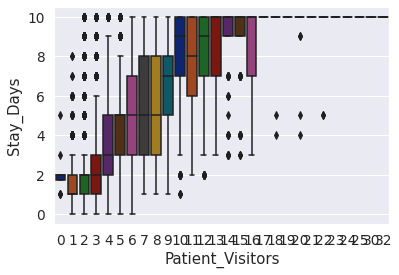

In [ ]:
sns.boxplot(y='Stay_Days', x='Patient_Visitors', data = train, palette = 'dark')
plt.show()

#### Admission_Deposit

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skew is: 0.9305211225853525


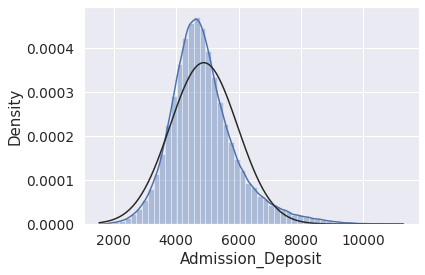

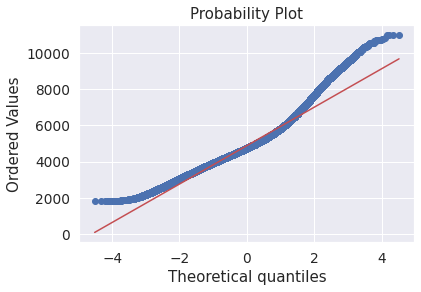

In [ ]:
sns.distplot(train['Admission_Deposit'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['Admission_Deposit'], plot=plt)
print ("Skew is:", train.Admission_Deposit.skew())

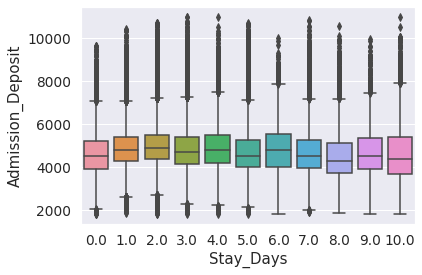

In [ ]:
sns.boxplot(x='Stay_Days', y='Admission_Deposit', data = train)


Dữ liệu bị skew, các cột tương tự nhau.

#### Age

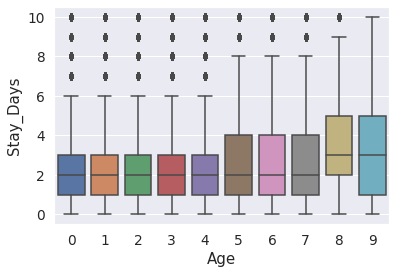

In [ ]:
sns.boxplot(y='Stay_Days', x='Age', data = train)


Age cao thi Stay_Days co xu huong tăng

#### Illness_Severity

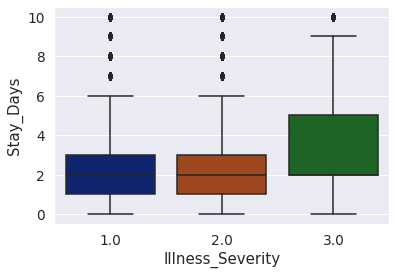

In [ ]:
sns.boxplot(y='Stay_Days', x='Illness_Severity', data = train, palette = 'dark')
plt.show()

Stay_Days cao khi Illness_Severity cao

#### Ward_Type

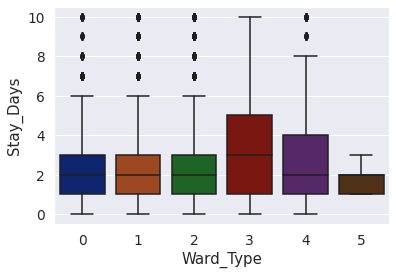

In [ ]:
sns.boxplot(y='Stay_Days', x='Ward_Type', data = train, palette = 'dark')
plt.show()

Stay_Days cao khi Ward_Type cao

# **4. Modeling and evaluation**

In [ ]:
y_train = train['Stay_Days'].copy()
X_train = train.copy()
X_train.drop(columns='Stay_Days',inplace=True)
X_test = X_test

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(222906, 89) (95532, 89) (222906,) (95532,)


## Clasification

### Chia thành 3 class

In [ ]:
y_classify_train = y_train.copy()
y_classify_train[y_train<=2] = 1
y_classify_train[(y_train<=5) & (y_train>=3)] = 2
y_classify_train[y_train>=6] = 3

In [ ]:
y_classify_test = y_test
y_classify_test[y_test<=2] = 1
y_classify_test[(y_test<=5) & (y_test>=3)] = 2
y_classify_test[y_test>=6] = 3

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


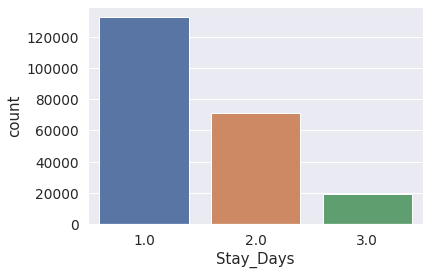

In [ ]:
sns.countplot(y_classify_train)

### LogReg

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_classify_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_classify_test, y_pred))
print(confusion_matrix(y_classify_test,y_pred))


              precision    recall  f1-score   support

         1.0       0.74      0.93      0.82     56774
         2.0       0.62      0.44      0.51     30573
         3.0       0.65      0.24      0.35      8185

    accuracy                           0.71     95532
   macro avg       0.67      0.54      0.56     95532
weighted avg       0.70      0.71      0.68     95532

[[52621  3995   158]
 [16298 13383   892]
 [ 1890  4309  1986]]


### Random Forest

In [ ]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_classify_test, y_pred))
print(confusion_matrix(y_classify_test,y_pred))

              precision    recall  f1-score   support

         1.0       0.77      0.90      0.83     56551
         2.0       0.62      0.51      0.56     30699
         3.0       0.65      0.33      0.44      8282

    accuracy                           0.73     95532
   macro avg       0.68      0.58      0.61     95532
weighted avg       0.71      0.73      0.71     95532

[[51005  5268   278]
 [13980 15574  1145]
 [ 1451  4133  2698]]


### XGBClassifier

In [ ]:
model = XGBClassifier()
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_classify_test, y_pred))
print(confusion_matrix(y_classify_test,y_pred))

              precision    recall  f1-score   support

         1.0       0.75      0.96      0.84     56551
         2.0       0.69      0.45      0.54     30699
         3.0       0.73      0.29      0.41      8282

    accuracy                           0.74     95532
   macro avg       0.72      0.56      0.60     95532
weighted avg       0.73      0.74      0.71     95532

[[54195  2225   131]
 [16142 13813   744]
 [ 1792  4122  2368]]


## Regression

### LinearRegression

In [ ]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test,y_pred,squared=False)

1.6706927160337472

### Random Forest

In [ ]:
model = RandomForestRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test,y_pred,squared=False)

1.5716676821525999

### XGBoost

In [ ]:
model = XGBRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test,y_pred,squared=False)

[17:18:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


1.575272330430222

### Tuning

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

#General function for building a model
def rf_cv(X, y, **kwargs):
    estimator = RandomForestRegressor(**kwargs)
    cval = cross_val_score(estimator, X, y, scoring = 'neg_mean_squared_error', cv = 4, verbose = 2, n_jobs = -1)
    return cval.mean()


def bayesian_optimise_rf(X, y, n_iter = 10):
    def rf_crossval(max_depth,min_samples_leaf,min_samples_split):
        #Wrapper of RandomForest cross validation.
        #Note the fixing of the inputs so they match the expected type
        #(e.g n_estimators must be an integer)
        return rf_cv(
            X = X,
            y = y,
            max_depth = int(max_depth),
            min_samples_leaf = int(min_samples_leaf),
            min_samples_split = int(min_samples_split),
            bootstrap = True
        )
    
    optimizer = BayesianOptimization(
        f = rf_crossval,
        pbounds =  {    'max_depth': (4, 20),
                        'min_samples_leaf': (1,15),
                        'min_samples_split': (2,15)}
    )
    optimizer.maximize(n_iter = n_iter)
    print("Final result:", optimizer.max)

In [ ]:
bayesian_optimise_rf(X_train,y_train)

|   iter    |  target   | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.0min finished


|  1        | -2.554    |  6.598    |  2.093    |  11.18    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.7min finished


|  2        | -2.436    |  10.57    |  10.0     |  7.178    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.2min finished


|  3        | -2.48     |  8.774    |  3.342    |  6.731    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


|  4        | -2.454    |  9.917    |  11.97    |  13.67    |


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.6min finished


|  5        | -2.455    |  9.337    |  11.13    |  6.346    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.4min finished


|  6        | -2.4      |  14.88    |  11.14    |  9.157    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.1min finished


|  7        | -2.393    |  18.73    |  8.13     |  4.719    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.1min finished


|  8        | -2.392    |  20.0     |  15.0     |  2.0      |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.1min finished


|  9        | -2.392    |  20.0     |  15.0     |  15.0     |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.3min finished


|  10       | -2.391    |  20.0     |  5.819    |  15.0     |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.7min finished


|  11       | -2.407    |  20.0     |  1.0      |  2.0      |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.1min finished


|  12       | -2.394    |  20.0     |  15.0     |  8.475    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.5min finished


|  13       | -2.396    |  20.0     |  1.0      |  10.01    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  7.0min finished


|  14       | -2.392    |  20.0     |  8.673    |  10.63    |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.0min finished


|  15       | -2.398    |  14.65    |  7.336    |  2.0      |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  6.6min finished


|  16       | -2.398    |  15.42    |  15.0     |  2.0      |


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
model = RandomForestRegressor(max_depth = 20, min_samples_leaf = 5, min_samples_split = 15)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=5, min_samples_split=15)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_test,y_pred,squared=False)

1.5409054360923051